# Análisis de Complejidad del Algoritmo de Programación Dinámica - Segunda Parte: "Mateo Empieza a Jugar"

In [ ]:
from random import seed
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

### Creación del Archivo que Contendrá la Función para Calcular el Tiempo de Ejecución

In [ ]:
%%writefile util.py

from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

RUNS_PER_SIZE = 10
MAX_WORKERS = max((os.cpu_count() or 1) // 4, 1)

def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start

def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

Writing util.py


### Creación del Archivo con el Algoritmo de Solución Mediante Programación Dinámica

In [ ]:
%%writefile solucion_dinamica.py

def quitar_rama(l, r, m: list):
    if m[l] >= m[r]:
        return l+1, r
    return l, r-1

def solucion_dinamica(monedas: list):
    n = len(monedas)
    M = [[0 for j in range(n)] for i in range(n)]

    for largo in range(1, n+1):
        for left_index in range(0, n-largo+1):
            right_index = left_index + largo - 1

            if largo > 2:
                Amateo_l, Amateo_r = quitar_rama(left_index + 1, right_index, monedas)
                Bmateo_l, Bmateo_r = quitar_rama(left_index, right_index - 1, monedas)

                M[left_index][right_index] = max(
                    monedas[left_index] + M[Amateo_l][Amateo_r],
                    monedas[right_index] + M[Bmateo_l][Bmateo_r]
                )
            else:
                M[left_index][right_index] = max(monedas[left_index], monedas[right_index])

    return M, M[0][n-1]

Writing solucion_dinamica.py


In [ ]:
from util import time_algorithm
from solucion_dinamica import solucion_dinamica

In [ ]:
# Seeds para que los resultados sean reproducibles
seed(10)
np.random.seed(10)

## Medición y Visualización del Tiempo de Ejecución del Algoritmo
En esta sección, generamos arreglos de distintos tamaños y medimos el tiempo de ejecución de nuestro algoritmo de programación dinámica para cada tamaño. Los resultados se grafican para observar cómo el tiempo de ejecución varía con el tamaño del array, lo que permite analizar la complejidad temporal del algoritmo. Esto nos ayudará a validar la complejidad teórica esperada y a evaluar el rendimiento en diferentes condiciones de entrada.
Se puede ver que el algoritmo tiene una tendencia cuadratia $O(n^2)$ que es lo esperado teoricamente.

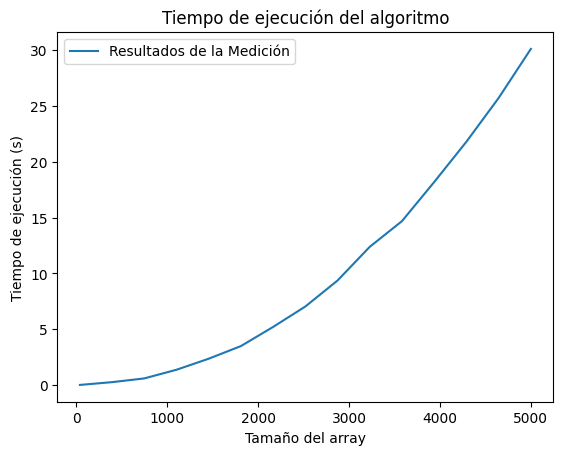

In [ ]:
def get_random_array(size: int):
    return np.random.randint(0, 10000, size)

x = np.linspace(40, 5000, 15).astype(int)

results = time_algorithm(solucion_dinamica, x, lambda s: [get_random_array(s)])


fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Resultados de la Medición")
ax.set_title('Tiempo de ejecución del algoritmo')
ax.set_xlabel('Tamaño del array')
ax.set_ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.show()


### Ajuste de la Complejidad con un Modelo Cuadrático

Realizamos un ajuste de las mediciones usando un modelo cuadrático para comparar gráficos.

El ajuste muestra una buena precisión (el error total es bajo y los graficos coinciden), lo cual confirma que el algoritmo tiene una complejidad cuadrática.


In [ ]:
# modelo cuadrático para el ajuste
f = lambda x, c1, c2: c1 * x**2 + c2

# ajuste con mínimos cuadrados
c, pcov = sp.optimize.curve_fit(f, x, [results[n] for n in x])

print(f"c_1 = {c[0]}, c_2 = {c[1]}")
r = np.sum((f(x, *c) - [results[n] for n in x])**2)
print(f"Error cuadrático total: {r}")

c_1 = 1.1986779530063356e-06, c_2 = -0.24767567035625146
Error cuadrático total: 0.885226758187465


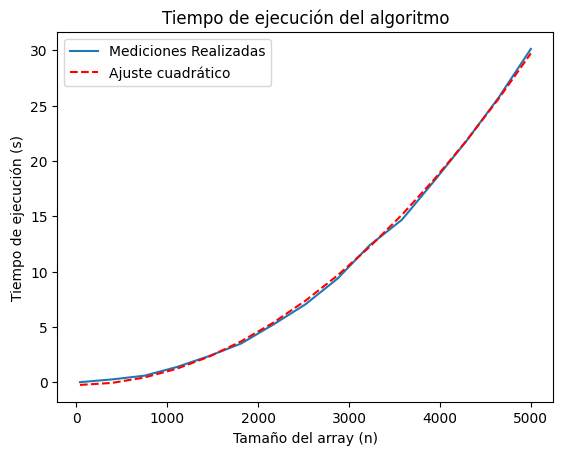

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, [results[n] for n in x], label="Mediciones Realizadas")
ax.plot(x, f(x, *c), 'r--', label="Ajuste cuadrático")
ax.set_title('Tiempo de ejecución del algoritmo')
ax.set_xlabel('Tamaño del array (n)')
ax.set_ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.show()

### Grafico de evolucion de error con tamaño del array

Finalmente se muestra como fue variando el error para los distintos tamaños del problema.

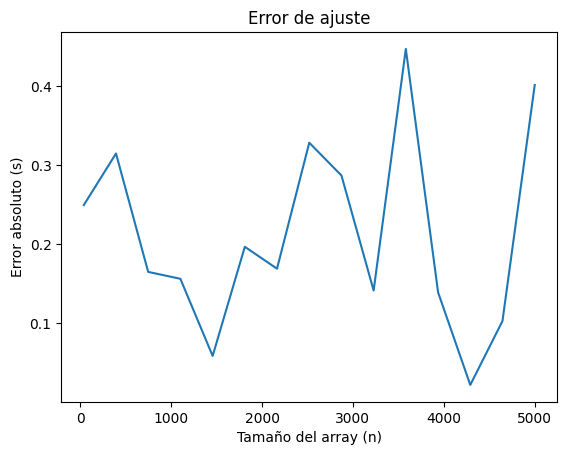

In [ ]:
fig, ax = plt.subplots()
errors = [np.abs(c[0] * n**2 + c[1] - results[n]) for n in x]
ax.plot(x, errors)
ax.set_title('Error de ajuste')
ax.set_xlabel('Tamaño del array (n)')
ax.set_ylabel('Error absoluto (s)')
plt.show()